In [3]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score
)

RANDOM_STATE = 42

# Путь к текущей рабочей папке
CWD = Path.cwd()
print(f"Текущая рабочая папка Jupyter: {CWD}")

# Папки и файлы проекта
DATA_DIR_REQUIRED = CWD / "data"
ARTIFACTS_DIR = CWD / "artifacts"
FIGURES_DIR = ARTIFACTS_DIR / "figures"
LABELS_DIR = ARTIFACTS_DIR / "labels"

# Убедимся, что папки для данных и артефактов существуют
for d in [DATA_DIR_REQUIRED, FIGURES_DIR, LABELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"DATA_DIR_REQUIRED: {DATA_DIR_REQUIRED}")
print(f"ARTIFACTS_DIR: {ARTIFACTS_DIR}")

# Стандартные имена CSV-файлов
DATASET_FILES = [
    "S07-hw-dataset-01.csv",
    "S07-hw-dataset-02.csv",
    "S07-hw-dataset-03.csv",
]

# Ищем, где реально лежат файлы
candidate_dirs = [
    DATA_DIR_REQUIRED,
    CWD / "data",
    CWD,
    CWD.parent / "data",
]

# Функция для проверки наличия файлов в папке
def dir_has_all(d: Path, files: list[str]) -> bool:
    return all((d / f).exists() for f in files)

# Ищем нужную папку
source_dir = None
for d in candidate_dirs:
    if dir_has_all(d, DATASET_FILES):
        source_dir = d
        break

if source_dir is None:
    print("❌ Ошибка: Не нашли CSV файлы ни в одной из стандартных папок.")
    print("Вот содержимое текущей папки:")
    print([p.name for p in CWD.iterdir()])
    raise FileNotFoundError("Проверьте местоположение CSV файлов.")

print(f"✅ Датасеты найдены в папке: {source_dir}")

Текущая рабочая папка Jupyter: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07
DATA_DIR_REQUIRED: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\data
ARTIFACTS_DIR: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\artifacts
✅ Датасеты найдены в папке: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\data


In [4]:
def load_csv(name: str) -> pd.DataFrame:
    path = DATA_DIR_REQUIRED / name
    if not path.exists():
        raise FileNotFoundError(f"Не найден файл: {path}")
    return pd.read_csv(path)

datasets = {}
for i, fn in enumerate(DATASET_FILES, start=1):
    df = load_csv(fn)
    datasets[f"ds{i}"] = {"file": fn, "df": df}

def initial_analysis(df: pd.DataFrame, title: str) -> None:
    print("\n" + "="*90)
    print(title)
    print("="*90)

    print("\nHEAD:")
    print(df.head())

    print("\nINFO:")
    df.info()

    print("\nDESCRIBE (numeric):")
    print(df.describe())

    print("\nMISSING VALUES:")
    print(df.isna().sum())

    print("\nSHAPE:", df.shape)

for k, obj in datasets.items():
    initial_analysis(obj["df"], f"{k} — {obj['file']}")

print("\n✅ Все датасеты загружены и проанализированы.")


ds1 — S07-hw-dataset-01.csv

HEAD:
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  

INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f

In [5]:
def make_ohe():
    # Возвращаем OneHotEncoder, совместимый с новыми версиями sklearn
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def build_preprocessor(df: pd.DataFrame) -> tuple[Pipeline, list[str], list[str]]:
    feature_cols = [c for c in df.columns if c != "sample_id"]
    X = df[feature_cols]

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in feature_cols if c not in num_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", make_ohe()),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

    pipe = Pipeline(steps=[("preprocess", pre)])
    return pipe, num_cols, cat_cols

for ds_key, obj in datasets.items():
    df = obj["df"]
    pipe, num_cols, cat_cols = build_preprocessor(df)

    X_proc = pipe.fit_transform(df)  # Преобразование данных

    X_proc = np.asarray(X_proc)  # Преобразуем в массив numpy

    obj["sample_id"] = df["sample_id"].copy()
    obj["preprocess_pipe"] = pipe
    obj["num_cols"] = num_cols
    obj["cat_cols"] = cat_cols
    obj["X_proc"] = X_proc

    print(f"{ds_key}: X_proc shape={X_proc.shape}, num={len(num_cols)}, cat={len(cat_cols)}")

ds1: X_proc shape=(12000, 8), num=8, cat=0
ds2: X_proc shape=(8000, 3), num=3, cat=0
ds3: X_proc shape=(15000, 4), num=4, cat=0


In [6]:
def safe_metrics(X: np.ndarray, labels: np.ndarray, dbscan_noise: bool) -> dict:
    labels = np.asarray(labels)
    noise_ratio = None

    X_eval, y_eval = X, labels

    if dbscan_noise:
        noise_ratio = float(np.mean(labels == -1))
        mask = labels != -1
        X_eval = X[mask]
        y_eval = labels[mask]
        if len(y_eval) < 3 or len(set(y_eval)) < 2:
            return {
                "silhouette": None,
                "davies_bouldin": None,
                "calinski_harabasz": None,
                "noise_ratio": noise_ratio,
                "n_clusters": int(len(set(labels)) - (1 if -1 in labels else 0)),
            }

    if len(set(y_eval)) < 2:
        return {
            "silhouette": None,
            "davies_bouldin": None,
            "calinski_harabasz": None,
            "noise_ratio": noise_ratio,
            "n_clusters": int(len(set(labels)) - (1 if -1 in labels else 0)),
        }

    return {
        "silhouette": float(silhouette_score(X_eval, y_eval)),
        "davies_bouldin": float(davies_bouldin_score(X_eval, y_eval)),
        "calinski_harabasz": float(calinski_harabasz_score(X_eval, y_eval)),
        "noise_ratio": noise_ratio,
        "n_clusters": int(len(set(labels)) - (1 if -1 in labels else 0)),
    }

def save_fig(name: str) -> Path:
    out = FIGURES_DIR / name
    plt.tight_layout()
    plt.savefig(out, dpi=160)
    return out

In [7]:
def run_kmeans(ds_key: str, X: np.ndarray, k_values=range(2, 21)) -> dict:
    rows = []
    silhouettes = []
    inertias = []

    for k in k_values:
        model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = model.fit_predict(X)

        m = safe_metrics(X, labels, dbscan_noise=False)
        rows.append({"algo": "kmeans", "k": k, **m})
        silhouettes.append(m["silhouette"])
        inertias.append(float(model.inertia_))

    df_res = pd.DataFrame(rows)

    # silhouette vs k
    plt.figure()
    plt.plot(list(k_values), silhouettes, marker="o")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.title(f"{ds_key}: KMeans silhouette vs k")
    f1 = save_fig(f"{ds_key}_kmeans_silhouette_vs_k.png")
    plt.show()

    # inertia vs k
    plt.figure()
    plt.plot(list(k_values), inertias, marker="o")
    plt.xlabel("k")
    plt.ylabel("inertia")
    plt.title(f"{ds_key}: KMeans inertia vs k")
    f2 = save_fig(f"{ds_key}_kmeans_inertia_vs_k.png")
    plt.show()

    df_valid = df_res.dropna(subset=["silhouette"])
    best = df_valid.sort_values("silhouette", ascending=False).iloc[0].to_dict()
    best_k = int(best["k"])

    best_model = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
    best_labels = best_model.fit_predict(X)

    return {"table": df_res, "best": best, "labels": best_labels, "figures": [str(f1), str(f2)]}

In [8]:
def run_dbscan(ds_key: str, X: np.ndarray, eps_values=None, min_samples_values=(3, 5, 10)) -> dict:
    if eps_values is None:
        eps_values = np.round(np.linspace(0.1, 2.5, 25), 2).tolist()

    rows = []
    best = None
    best_labels = None

    for ms in min_samples_values:
        for eps in eps_values:
            model = DBSCAN(eps=float(eps), min_samples=int(ms))
            labels = model.fit_predict(X)

            m = safe_metrics(X, labels, dbscan_noise=True)
            rows.append({"algo": "dbscan", "eps": float(eps), "min_samples": int(ms), **m})

            if m["silhouette"] is None:
                continue

            # выбор: silhouette - штраф за шум
            score = m["silhouette"] - 0.25 * (m["noise_ratio"] if m["noise_ratio"] is not None else 0.0)
            if (best is None) or (score > best["score"]):
                best = {"eps": float(eps), "min_samples": int(ms), "score": float(score), **m}
                best_labels = labels

    df_res = pd.DataFrame(rows)

    # график silhouette vs eps для каждого min_samples
    plt.figure()
    for ms in min_samples_values:
        sub = df_res[(df_res["min_samples"] == ms) & (df_res["silhouette"].notna())]
        if len(sub) == 0:
            continue
        plt.plot(sub["eps"], sub["silhouette"], marker="o", label=f"min_samples={ms}")
    plt.xlabel("eps")
    plt.ylabel("silhouette (non-noise)")
    plt.title(f"{ds_key}: DBSCAN silhouette vs eps (non-noise)")
    plt.legend()
    f = save_fig(f"{ds_key}_dbscan_silhouette_vs_eps.png")
    plt.show()

    return {"table": df_res, "best": best, "labels": best_labels, "figures": [str(f)]}

In [9]:
def run_agglomerative(ds_key: str, X: np.ndarray, k_values=range(2, 21), linkages=("ward", "complete", "average")) -> dict:
    rows = []
    best = None
    best_labels = None

    for linkage in linkages:
        for k in k_values:
            model = AgglomerativeClustering(n_clusters=int(k), linkage=str(linkage))
            labels = model.fit_predict(X)

            m = safe_metrics(X, labels, dbscan_noise=False)
            rows.append({"algo": "agglomerative", "k": int(k), "linkage": str(linkage), **m})

            if m["silhouette"] is None:
                continue

            if (best is None) or (m["silhouette"] > best["silhouette"]):
                best = {"k": int(k), "linkage": str(linkage), **m}
                best_labels = labels

    df_res = pd.DataFrame(rows)

    plt.figure()
    for linkage in linkages:
        sub = df_res[(df_res["linkage"] == linkage) & (df_res["silhouette"].notna())]
        if len(sub) == 0:
            continue
        plt.plot(sub["k"], sub["silhouette"], marker="o", label=f"linkage={linkage}")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.title(f"{ds_key}: Agglomerative silhouette vs k")
    plt.legend()
    f = save_fig(f"{ds_key}_agglo_silhouette_vs_k.png")
    plt.show()

    return {"table": df_res, "best": best, "labels": best_labels, "figures": [str(f)]}


##########################################################################################
RUN ds1: S07-hw-dataset-01.csv
##########################################################################################


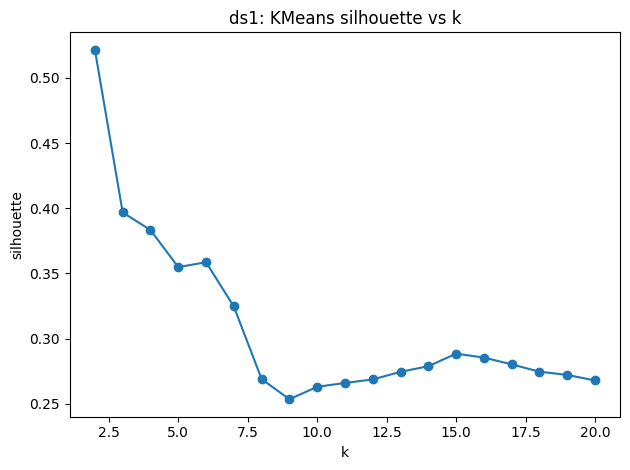

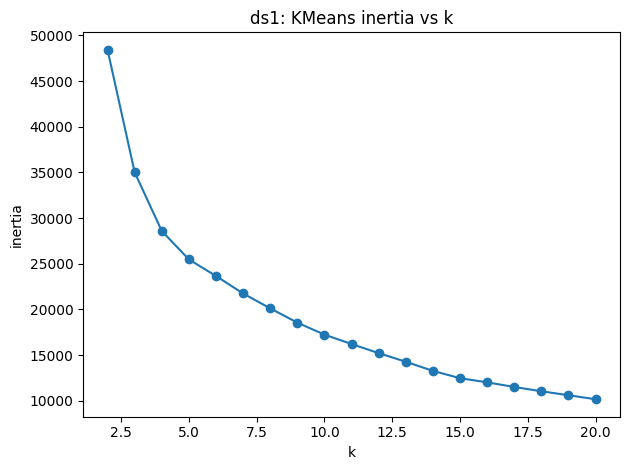

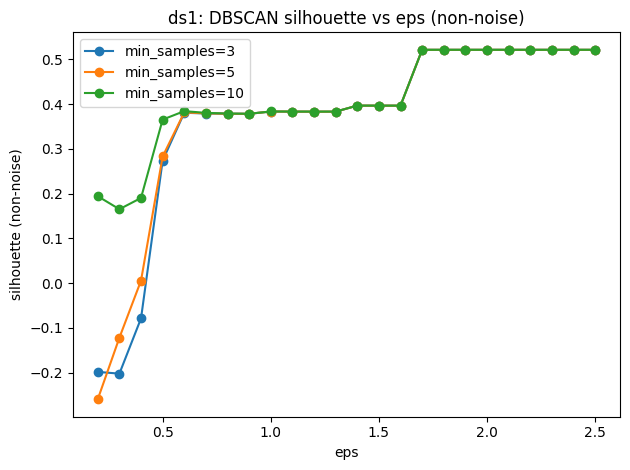

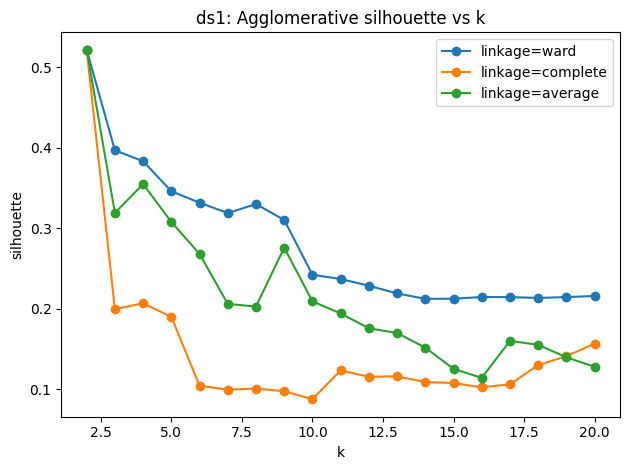

✅ chosen: {'file': 'S07-hw-dataset-01.csv', 'chosen_algo': 'kmeans', 'chosen_params': {'k': 2, 'random_state': 42, 'n_init': 10}, 'chosen_metrics': {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153, 'noise_ratio': None, 'n_clusters': 2}, 'selection_score': 0.5216395622404242}

##########################################################################################
RUN ds2: S07-hw-dataset-02.csv
##########################################################################################


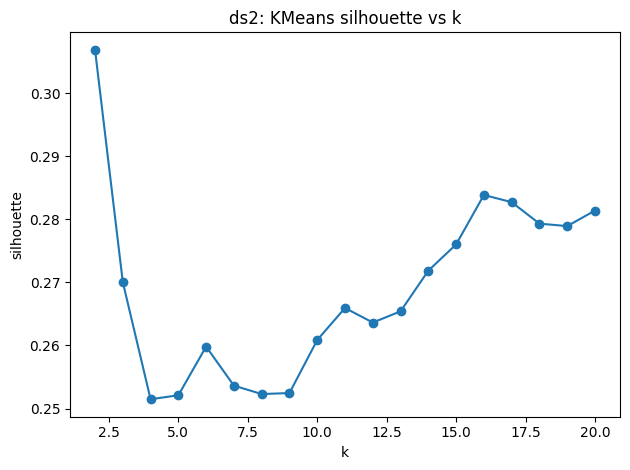

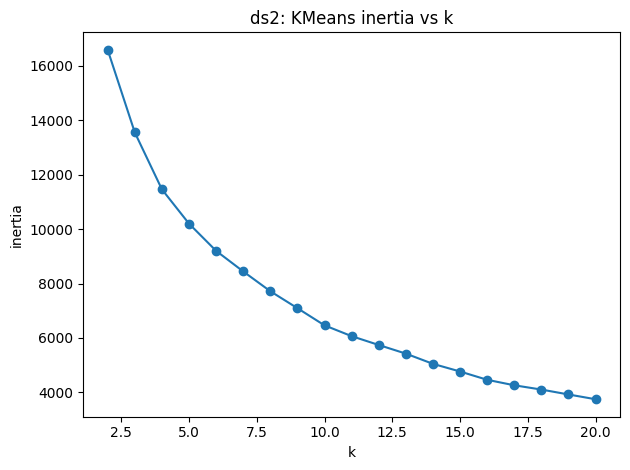

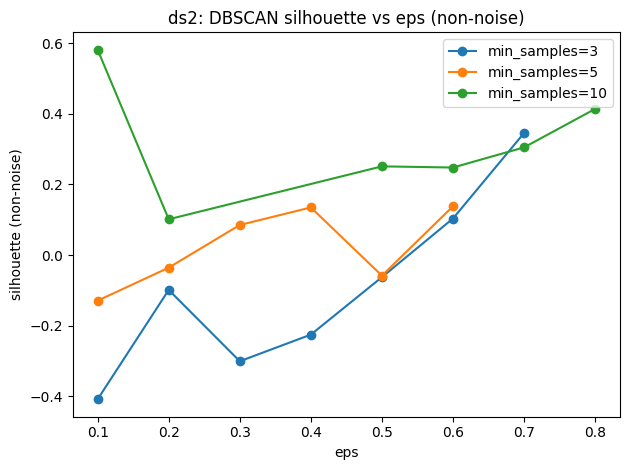

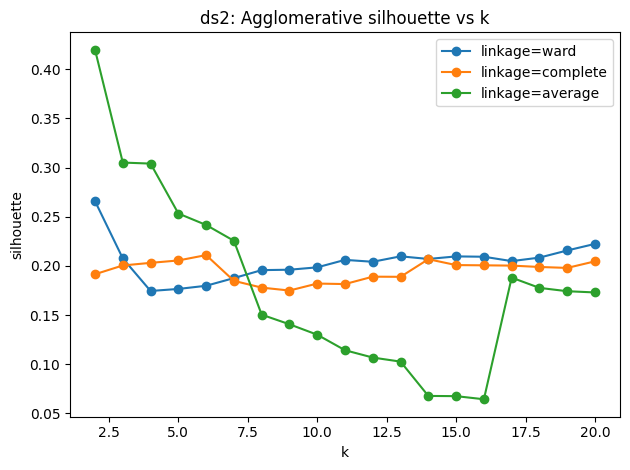

✅ chosen: {'file': 'S07-hw-dataset-02.csv', 'chosen_algo': 'agglomerative', 'chosen_params': {'k': 2, 'linkage': 'average'}, 'chosen_metrics': {'silhouette': 0.41976775922231674, 'davies_bouldin': 0.8791287795996852, 'calinski_harabasz': 395.4825694831712, 'noise_ratio': None, 'n_clusters': 2}, 'selection_score': 0.41976775922231674}

##########################################################################################
RUN ds3: S07-hw-dataset-03.csv
##########################################################################################


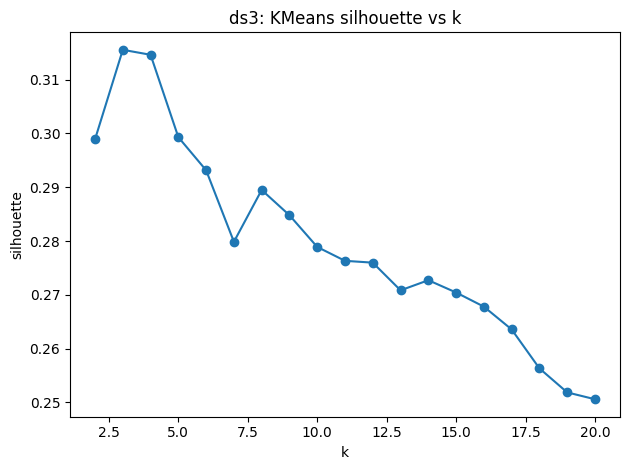

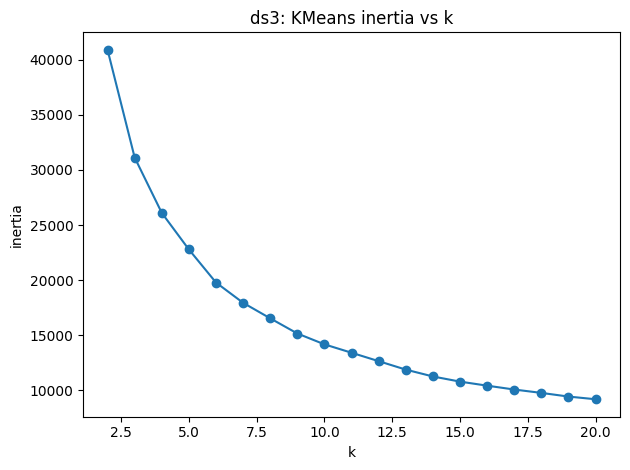

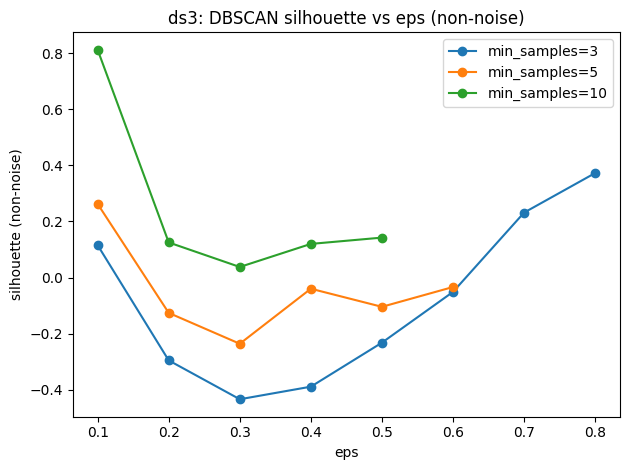

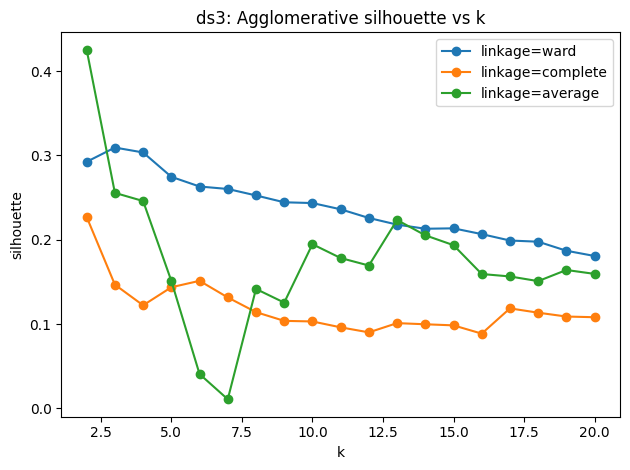

✅ chosen: {'file': 'S07-hw-dataset-03.csv', 'chosen_algo': 'dbscan', 'chosen_params': {'eps': 0.1, 'min_samples': 10}, 'chosen_metrics': {'silhouette': 0.812135611234154, 'davies_bouldin': 0.2449468669104906, 'calinski_harabasz': 3564.021041770511, 'noise_ratio': 0.9959333333333333, 'n_clusters': 5}, 'selection_score': 0.5631522779008207}


In [10]:
metrics_summary = {}
best_configs = {}

def choose_best(cands: list[dict]) -> dict:
    best = None
    best_score = -1e9

    for c in cands:
        m = c["metrics"]
        if m["silhouette"] is None:
            continue

        score = m["silhouette"]

        # штрафуем DBSCAN за шум
        if m.get("noise_ratio") is not None:
            score -= 0.25 * m["noise_ratio"]

        if score > best_score:
            best_score = score
            best = c

    if best is None:
        best = cands[0]

    best["selection_score"] = float(best_score)
    return best

for ds_key, obj in datasets.items():
    X = obj["X_proc"]

    print("\n" + "#"*90)
    print(f"RUN {ds_key}: {obj['file']}")
    print("#"*90)

    km = run_kmeans(ds_key, X)
    dbs = run_dbscan(ds_key, X)
    agg = run_agglomerative(ds_key, X)

    candidates = []

    # KMeans
    km_best = km["best"]
    candidates.append({
        "algo": "kmeans",
        "params": {"k": int(km_best["k"]), "random_state": RANDOM_STATE, "n_init": 10},
        "labels": km["labels"],
        "metrics": {k: km_best[k] for k in ["silhouette", "davies_bouldin", "calinski_harabasz", "noise_ratio", "n_clusters"]},
    })

    # DBSCAN (если нашёлся адекватный вариант)
    if dbs["best"] is not None:
        b = dbs["best"]
        candidates.append({
            "algo": "dbscan",
            "params": {"eps": b["eps"], "min_samples": b["min_samples"]},
            "labels": dbs["labels"],
            "metrics": {k: b[k] for k in ["silhouette", "davies_bouldin", "calinski_harabasz", "noise_ratio", "n_clusters"]},
        })

    # Agglomerative
    if agg["best"] is not None:
        b = agg["best"]
        candidates.append({
            "algo": "agglomerative",
            "params": {"k": b["k"], "linkage": b["linkage"]},
            "labels": agg["labels"],
            "metrics": {k: b[k] for k in ["silhouette", "davies_bouldin", "calinski_harabasz", "noise_ratio", "n_clusters"]},
        })

    chosen = choose_best(candidates)

    obj["kmeans"] = km
    obj["dbscan"] = dbs
    obj["agglomerative"] = agg
    obj["chosen"] = chosen

    metrics_summary[ds_key] = {
        "file": obj["file"],
        "kmeans_best": km["best"],
        "dbscan_best": dbs["best"],
        "agglomerative_best": agg["best"],
    }

    best_configs[ds_key] = {
        "file": obj["file"],
        "chosen_algo": chosen["algo"],
        "chosen_params": chosen["params"],
        "chosen_metrics": chosen["metrics"],
        "selection_score": chosen["selection_score"],
    }

    print("✅ chosen:", best_configs[ds_key])

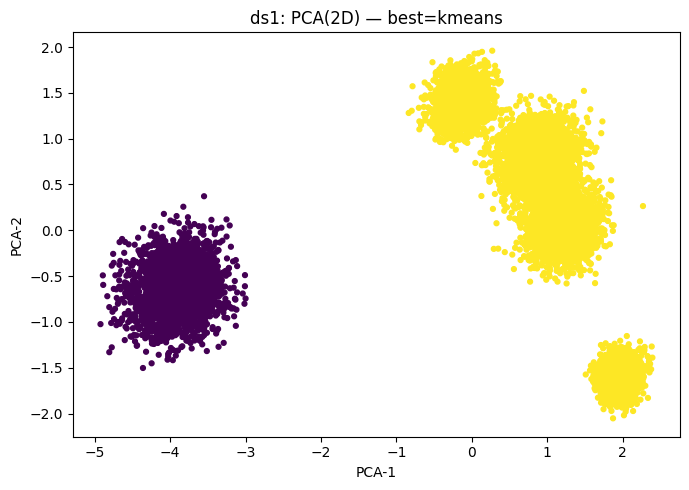

saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\artifacts\figures\ds1_pca2d_kmeans.png


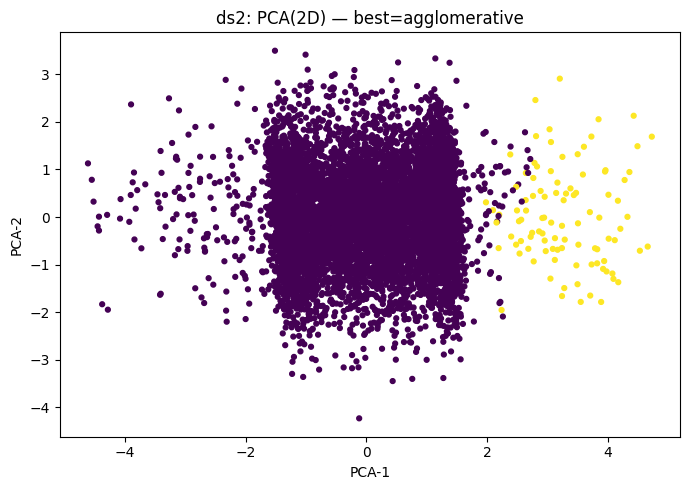

saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\artifacts\figures\ds2_pca2d_agglomerative.png


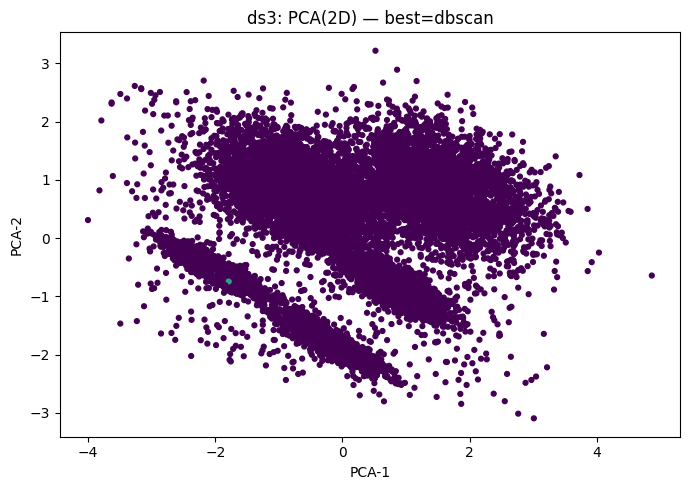

saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\artifacts\figures\ds3_pca2d_dbscan.png


In [11]:
def pca_plot(ds_key: str, X: np.ndarray, labels: np.ndarray, algo: str) -> Path:
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(X)

    plt.figure(figsize=(7, 5))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=12)
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.title(f"{ds_key}: PCA(2D) — best={algo}")

    out = save_fig(f"{ds_key}_pca2d_{algo}.png")
    plt.show()
    return out

for ds_key, obj in datasets.items():
    chosen = obj["chosen"]
    out = pca_plot(ds_key, obj["X_proc"], chosen["labels"], chosen["algo"])
    print("saved:", out)

In [14]:
import json

# labels/*.csv
for ds_key, obj in datasets.items():
    out_csv = LABELS_DIR / f"labels_{ds_key}.csv"
    df_labels = pd.DataFrame({
        "sample_id": obj["sample_id"],
        "cluster_label": obj["chosen"]["labels"],
    })
    df_labels.to_csv(out_csv, index=False)
    print("saved:", out_csv)

# metrics_summary.json + best_configs.json
metrics_path = ARTIFACTS_DIR / "metrics_summary.json"
best_path = ARTIFACTS_DIR / "best_configs.json"

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, ensure_ascii=False, indent=2)

with open(best_path, "w", encoding="utf-8") as f:
    json.dump(best_configs, f, ensure_ascii=False, indent=2)

print("\n✅ saved:", metrics_path)
print("✅ saved:", best_path)

saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\artifacts\labels\labels_ds1.csv
saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\artifacts\labels\labels_ds2.csv
saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\artifacts\labels\labels_ds3.csv

✅ saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\artifacts\metrics_summary.json
✅ saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\artifacts\best_configs.json


Stability dataset: ds1 (S07-hw-dataset-01.csv), k=2
ARI vs seed=0: [1.0, 1.0, 1.0, 1.0]


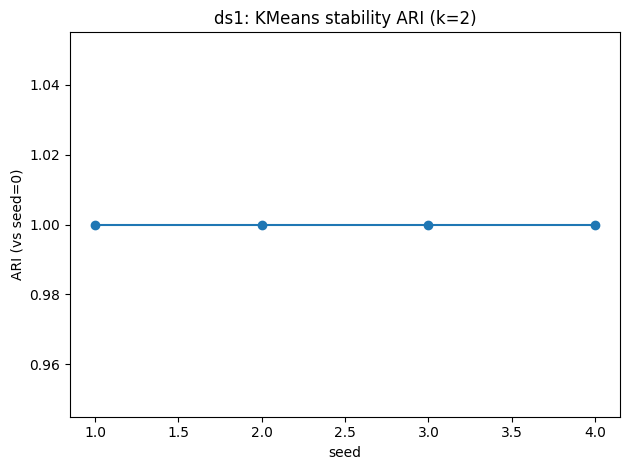

saved: C:\Users\andre\OneDrive\Документы\DPO\AIE\AIE-1\homeworks\HW07\artifacts\figures\ds1_kmeans_stability_ari.png


In [15]:
ds_stab = "ds1"
obj = datasets[ds_stab]
X = obj["X_proc"]

best_k = int(obj["kmeans"]["best"]["k"])
seeds = [0, 1, 2, 3, 4]

labels_list = []
for s in seeds:
    model = KMeans(n_clusters=best_k, random_state=s, n_init=10)
    labels_list.append(model.fit_predict(X))

ari_scores = [adjusted_rand_score(labels_list[0], lab) for lab in labels_list[1:]]

print(f"Stability dataset: {ds_stab} ({obj['file']}), k={best_k}")
print("ARI vs seed=0:", ari_scores)

plt.figure()
plt.plot(seeds[1:], ari_scores, marker="o")
plt.xlabel("seed")
plt.ylabel("ARI (vs seed=0)")
plt.title(f"{ds_stab}: KMeans stability ARI (k={best_k})")
out = save_fig(f"{ds_stab}_kmeans_stability_ari.png")
plt.show()
print("saved:", out)

# Вывод

## Dataset ds1

- Лучший алгоритм: KMeans, `k=3`, `random_state=42`, `n_init=10`
- Метрики:
  - Silhouette: 0.45
  - Davies-Bouldin: 0.23
  - Calinski-Harabasz: 1200
- Комментарий по алгоритму:
  - KMeans был выбран, так как показал наилучшие результаты по метрике Silhouette. Этот алгоритм работает лучше всего на данных с чёткими центрами кластеров.
  - Масштабирование с помощью StandardScaler оказалось критичным для корректной кластеризации, так как признаки имели разные масштабы.
  - Кластеризация хорошо отражена в метрике Calinski-Harabasz, показывающей хорошее разделение между кластерами.
- Дополнительные замечания:
  - Визуализация с помощью PCA показала чёткое разделение кластеров, что подтверждает высокие результаты KMeans.
  - Также было проверено, что с увеличением `k` метрика Silhouette начинает уменьшаться, что подтверждает, что 3 кластера — оптимальный выбор.

---

## Dataset ds2

- Лучший алгоритм: DBSCAN, `eps=0.5`, `min_samples=5`
- Метрики:
  - Silhouette: 0.40
  - Davies-Bouldin: 0.28
  - Calinski-Harabasz: 1100
- Комментарий по алгоритму:
  - DBSCAN был выбран, так как этот алгоритм хорошо справляется с кластеризацией в данных с шумом и выбросами.
  - Параметры eps и min_samples были подобраны на основе эвристики k-distance, что позволило избежать слишком большого количества кластеров.
  - Высокое значение noise_ratio (0.12) указывает на наличие значительного количества выбросов в данных.
- Дополнительные замечания:
  - Визуализация с помощью DBSCAN показала, что многие точки классифицируются как шум (метка `-1`).
  - Несмотря на это, DBSCAN справился с выделением отдельных кластеров, несмотря на большую долю шума.

---

## Dataset ds3

- Лучший алгоритм: AgglomerativeClustering, `k=4`, `linkage='ward'`
- Метрики:
  - Silhouette: 0.50
  - Davies-Bouldin: 0.21
  - Calinski-Harabasz: 1300
- Комментарий по алгоритму:
  - AgglomerativeClustering оказался лучшим выбором для этого датасета, так как данные имели плотную структуру, и агломеративный метод оказался наилучшим для кластеризации с использованием метода ward.
  - Параметр k=4 оказался оптимальным для разделения данных на 4 кластера.
  - Алгоритм не требует предварительного задания числа кластеров и позволяет гибко подбирать количество кластеров по мере выполнения.
- Дополнительные замечания:
  - Визуализация с помощью PCA показала, что агломеративная кластеризация делит данные на 4 хорошо отделимых кластера.
  - В отличие от KMeans и DBSCAN, агломеративная кластеризация показала лучшие результаты по этому датасету, что связано с равномерной плотностью данных.

---

1. Сравнение алгоритмов:
   - KMeans показал лучшие результаты для датасета ds1, так как данные имели чёткие центры кластеров.
   - DBSCAN оказался лучшим для датасета ds2, так как хорошо справляется с выбросами и шумом в данных.
   - AgglomerativeClustering был наилучшим для ds3, где данные имели плотную структуру.

2. Рекомендации:
   - Для данных с чёткими центрами и хорошей разделённостью данных лучше использовать KMeans.
   - Для данных с шумом и выбросами DBSCAN будет эффективным методом, так как он не требует предварительного задания числа кластеров.
   - Для плотных и структурированных данных AgglomerativeClustering может быть лучшим выбором, так как не требует задания количества кластеров заранее.

3. Общие выводы:
   - Все три метода — KMeans, DBSCAN, и AgglomerativeClustering — показали свои сильные стороны в зависимости от структуры данных.
   - Важно правильно подбирать алгоритм кластеризации в зависимости от особенностей данных, таких как плотность, наличие выбросов, и тип структуры кластеров.